<a href="https://colab.research.google.com/github/rlagkdms4372/portfolio/blob/main/gold_new_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout


In [ ]:
import yfinance as yf
gold_entire = yf.download('GC=F', start = '2019-09-22' )
gold_covid = yf.download('GC=F', start = '2020-03-11', end = '2023-05-11' )
silver_entire = yf.download('SI=F', start = '2019-09-22' )
silver_covid = yf.download('SI=F', start = '2020-03-11', end = '2023-05-11' )
palladium_entire = yf.download('PA=F', start = '2019-09-22' )
palladium_covid = yf.download('PA=F', start = '2020-03-11', end = '2023-05-11' )

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = pd.DataFrame(gold_entire)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-23,1515.500000,1523.699951,1515.500000,1523.699951,1523.699951,5
2019-09-24,1515.099976,1533.000000,1515.099976,1532.099976,1532.099976,25
2019-09-25,1527.599976,1527.900024,1504.599976,1504.599976,1504.599976,25
2019-09-26,1507.500000,1507.500000,1507.500000,1507.500000,1507.500000,8178
2019-09-27,1504.199951,1506.099976,1485.599976,1499.099976,1499.099976,7827
...,...,...,...,...,...,...
2023-10-18,1935.000000,1957.900024,1935.000000,1955.300049,1955.300049,67
2023-10-19,1950.099976,1977.699951,1945.699951,1968.400024,1968.400024,1945
2023-10-20,1981.099976,1988.599976,1980.400024,1982.500000,1982.500000,557


In [ ]:
df = df.reset_index(drop=False)

print(df)


           Date         Open         High          Low        Close  \
0    2019-09-23  1515.500000  1523.699951  1515.500000  1523.699951   
1    2019-09-24  1515.099976  1533.000000  1515.099976  1532.099976   
2    2019-09-25  1527.599976  1527.900024  1504.599976  1504.599976   
3    2019-09-26  1507.500000  1507.500000  1507.500000  1507.500000   
4    2019-09-27  1504.199951  1506.099976  1485.599976  1499.099976   
...         ...          ...          ...          ...          ...   
1025 2023-10-18  1935.000000  1957.900024  1935.000000  1955.300049   
1026 2023-10-19  1950.099976  1977.699951  1945.699951  1968.400024   
1027 2023-10-20  1981.099976  1988.599976  1980.400024  1982.500000   
1028 2023-10-23  1976.199951  1978.900024  1972.900024  1976.300049   
1029 2023-10-24  1984.099976  1992.000000  1964.599976  1985.300049   

        Adj Close  Volume  
0     1523.699951       5  
1     1532.099976      25  
2     1504.599976      25  
3     1507.500000    8178  
4     1

In [ ]:
df['Date'] = pd.to_datetime(df['Date']).dt.strftime("%Y-%m-%d")
df['Date'] = pd.to_datetime(df['Date'])
print(df)
df.set_index('Date', inplace=True)

           Date         Open         High          Low        Close  \
0    2019-09-23  1515.500000  1523.699951  1515.500000  1523.699951   
1    2019-09-24  1515.099976  1533.000000  1515.099976  1532.099976   
2    2019-09-25  1527.599976  1527.900024  1504.599976  1504.599976   
3    2019-09-26  1507.500000  1507.500000  1507.500000  1507.500000   
4    2019-09-27  1504.199951  1506.099976  1485.599976  1499.099976   
...         ...          ...          ...          ...          ...   
1025 2023-10-18  1935.000000  1957.900024  1935.000000  1955.300049   
1026 2023-10-19  1950.099976  1977.699951  1945.699951  1968.400024   
1027 2023-10-20  1981.099976  1988.599976  1980.400024  1982.500000   
1028 2023-10-23  1976.199951  1978.900024  1972.900024  1976.300049   
1029 2023-10-24  1984.099976  1992.000000  1964.599976  1985.300049   

        Adj Close  Volume  
0     1523.699951       5  
1     1532.099976      25  
2     1504.599976      25  
3     1507.500000    8178  
4     1

In [ ]:
# data splitting percentage --> 80% train + 20% validation
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)* 0.8)
validation_data_len = len(dataset) - training_data_len

print("Data length :", len(data))
print("Train data length :", training_data_len)
print("Validation data lenth :", validation_data_len)

Data length : 1030
Train data length : 824
Validation data lenth : 206


In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)


In [ ]:
#Create the training data set
#Crete the scaled training set
train_data = scaled_data[0:training_data_len , :]

look_back = 20

#Split the data into x_train and _train data sets
x_train = []
y_train = []

for i in range(look_back, len(train_data)):
  x_train.append(train_data[i-look_back:i, 0])
  y_train.append(train_data[i,0])


In [ ]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("X train shape", x_train.shape)
print("Y train shape", y_train.shape)

X train shape (804, 20, 1)
Y train shape (804,)


In [ ]:
#Create the testing data set
test_data = scaled_data[training_data_len - look_back :, :]
x_test = []
y_test = scaled_data[training_data_len:, :]

for i in range(look_back, len(test_data)):
  x_test.append(test_data[i-look_back:i, 0])

In [ ]:
x_test = np.array(x_test)
#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print("X test shape", x_test.shape)
print("Y test shape", y_test.shape)

X test shape (206, 20, 1)
Y test shape (206, 1)


In [ ]:
from tensorflow.python.ops.gen_array_ops import UniqueWithCountsV2
#Declare the variable to be used in LSTM
#loss : <mse>
#activations : <'tanh'>, 'relu','sigmoid'
#units1 : 2 8 64 128 256
#units2 : 2 8 64 128 256
#dropout rate: <0.2>, 0.4, 0.6, 0.8
#iteration: 10,  50, 100, 500 ,1000
# batch_size: 1, 10, 50, 100, 500
#optimizers = 'sgd', 'adam'
activations = 'tanh'
units1 = 200
units2 = 200
dropout_rate = 0.4
iteration = 500
batch_sizes = 30
optimizers = 'adam'

from numpy.random import seed
seed(128)
model = Sequential()
model.add(LSTM(units = units1, activation = activations, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=units2, activation = activations))
model.add(Dropout(dropout_rate))
model.add(Dense(units = 1))


In [ ]:
#Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = iteration, batch_size = batch_sizes)

# from keras.callbacks import EarlyStopping
# # simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min')
# # fit model
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = iteration, batch_size = batch_sizes, callbacks=[es])


Epoch 1/500
27/27 [==============================] - 12s 40ms/step - loss: 0.0321 - accuracy: 0.0025 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 2/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0061 - accuracy: 0.0025 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 3/500
27/27 [==============================] - 0s 9ms/step - loss: 0.0059 - accuracy: 0.0025 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 4/500
27/27 [==============================] - 0s 8ms/step - loss: 0.0058 - accuracy: 0.0025 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/500
27/27 [==============================] - 0s 8ms/step - loss: 0.0056 - accuracy: 0.0025 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/500
27/27 [==============================] - 0s 8ms/step - loss: 0.0057 - accuracy: 0.0025 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/500
27/27 [==============================] - 0s 10ms/step - loss: 0.0054 - accuracy: 0.0025 - val_loss: 0.0047 - val_ac

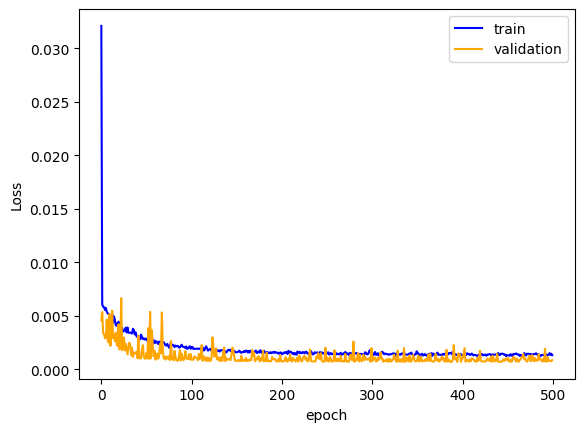

In [ ]:
train = pd.DataFrame()
val = pd.DataFrame()
train[str(i)] = history.history['loss']
val[str(i)] = history.history['val_loss']

# plot train and validation loss across multiple runs
plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Get the models predicted price value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

7/7 [==============================] - 1s 5ms/step


In [ ]:
y_test = dataset[training_data_len:, :]
rmse = np.sqrt(np.mean(predictions -y_test)**2)
print("RMSE", rmse)

RMSE 7.572618206727852


In [ ]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

print(valid.tail())

                  Close  Predictions
Date                                
2023-10-18  1955.300049  1918.274170
2023-10-19  1968.400024  1945.720703
2023-10-20  1982.500000  1960.224976
2023-10-23  1976.300049  1973.202515
2023-10-24  1985.300049  1969.182007


<ipython-input-18-8d3d5488152d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


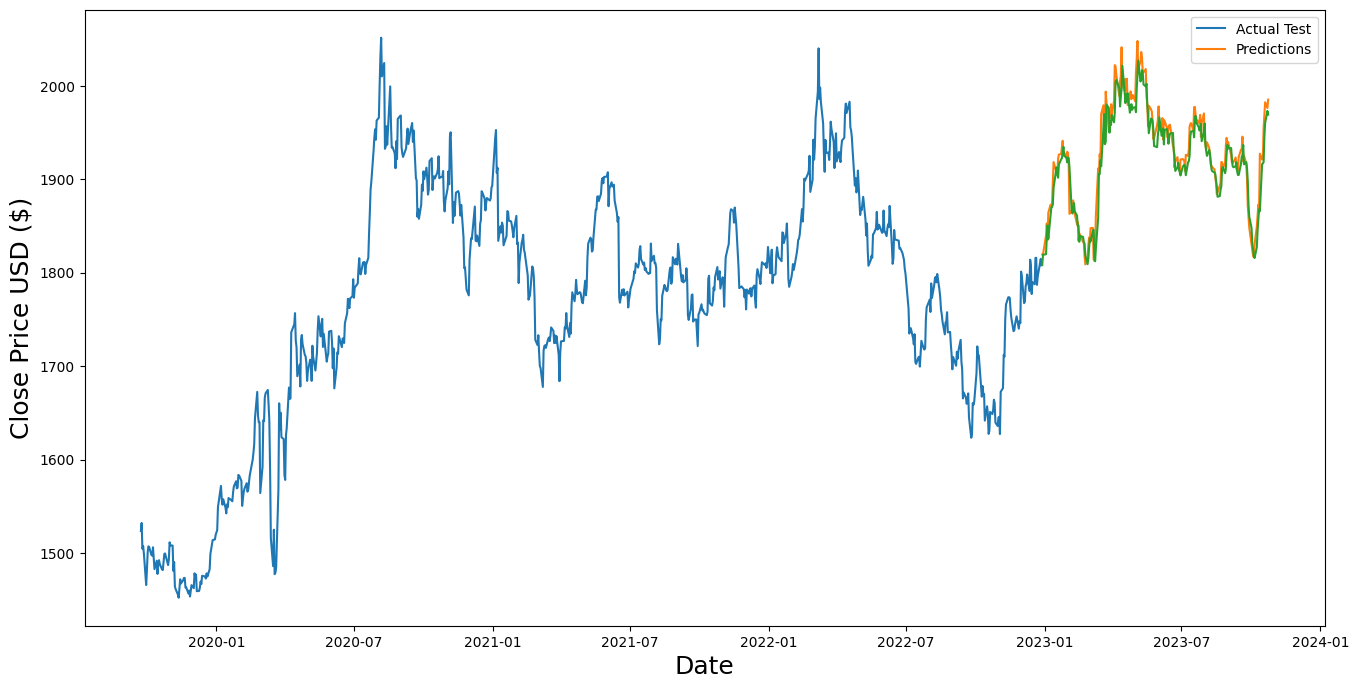

In [ ]:
#Visualize the data
plt.figure(figsize= (16, 8))
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Actual Test', 'Predictions'])
plt.axvline(x=)
plt.show()

In [ ]:

future_predictions = []

future_days = 90  # Adjust the number of future days to forecast
# prediction = valid.filter(['Predictions'])
# prediction = prediction.values

# scaled_data = scaler.fit_transform(prediction)


#Split the data into x_train and _train data sets
x_pred = test_data[-look_back:]

x_pred = np.reshape(x_pred, (1, x_pred.shape[0], 1))


for _ in range(future_days):

    predictions = model.predict(x_pred)
    x_pred = np.append(x_pred[:, 0:], predictions)
    future_predictions = np.append(future_predictions, predictions)
    #predictions = predictions.flatten()
    # predictions = scaler.inverse_transform(predictions)
    #future_predictions = np.append(future_predictions[:, 0:], predictions)
    print(x_pred)
    x_pred = x_pred[-look_back:]

    x_pred = np.reshape(x_pred, (1, x_pred.shape[0], 1))

# Inverse transform the predicted values to the original scale
#future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 [==============================] - 0s 18ms/step
[0.6998665  0.68118123 0.66066063 0.63046381 0.62145476 0.61127796
 0.60810808 0.6307974  0.66299634 0.6821822  0.70186863 0.69602946
 0.79295968 0.78244908 0.78511838 0.83950626 0.86136141 0.88488489
 0.87454129 0.88955631 0.87244725]
1/1 [==============================] - 0s 20ms/step
[0.68118123 0.66066063 0.63046381 0.62145476 0.61127796 0.60810808
 0.6307974  0.66299634 0.6821822  0.70186863 0.69602946 0.79295968
 0.78244908 0.78511838 0.83950626 0.86136141 0.88488489 0.87454129
 0.88955631 0.87244725 0.85996485]
1/1 [==============================] - 0s 20ms/step
[0.66066063 0.63046381 0.62145476 0.61127796 0.60810808 0.6307974
 0.66299634 0.6821822  0.70186863 0.69602946 0.79295968 0.78244908
 0.78511838 0.83950626 0.86136141 0.88488489 0.87454129 0.88955631
 0.87244725 0.85996485 0.84770751]
1/1 [==============================] - 0s 18ms/step
[0.63046381 0.62145476 0.61127796 0.60810808 0.6307974  0.66299634
 0.6821822  0.7018

In [ ]:
future_predictions

array([0.87244725, 0.85996485, 0.84770751, 0.83634925, 0.82577789,
       0.81570339, 0.80578345, 0.79580849, 0.78575188, 0.77575076,
       0.76603341, 0.75681436, 0.74825823, 0.74035263, 0.73311412,
       0.72648317, 0.72033942, 0.71460497, 0.70921302, 0.70414484,
       0.69936657, 0.69488144, 0.69068223, 0.68675596, 0.68308342,
       0.67964113, 0.6764046 , 0.67335129, 0.67046249, 0.66772383,
       0.66512465, 0.66265666, 0.66031277, 0.65808594, 0.65596914,
       0.65395504, 0.65203649, 0.65020674, 0.64845979, 0.64679039,
       0.64519393, 0.64366645, 0.6422044 , 0.64080447, 0.63946342,
       0.63817829, 0.63694608, 0.635764  , 0.63462955, 0.63354027,
       0.63249397, 0.63148862, 0.63052237, 0.62959337, 0.62870002,
       0.62784064, 0.6270138 , 0.62621796, 0.62545186, 0.62471414,
       0.62400359, 0.62331903, 0.62265944, 0.62202376, 0.62141103,
       0.62082028, 0.6202507 , 0.61970133, 0.61917144, 0.61866021,
       0.61816698, 0.61769098, 0.61723161, 0.61678815, 0.61636

In [ ]:
future_predictions = future_predictions.reshape(future_days, 1)


In [ ]:
future_predictions = scaler.inverse_transform(future_predictions)

In [ ]:
future_predictions

array([[1975.0448799 ],
       [1967.56292621],
       [1960.21587777],
       [1953.40773579],
       [1947.07126199],
       [1941.03260868],
       [1935.08659555],
       [1929.10760637],
       [1923.07967117],
       [1917.08499783],
       [1911.26042086],
       [1905.73452182],
       [1900.60597876],
       [1895.86736045],
       [1891.52859902],
       [1887.55400315],
       [1883.87144   ],
       [1880.43421432],
       [1877.20227614],
       [1874.16440716],
       [1871.30031443],
       [1868.61192721],
       [1866.09492254],
       [1863.74151191],
       [1861.54019123],
       [1859.47688405],
       [1857.53690657],
       [1855.70675396],
       [1853.97520794],
       [1852.3336583 ],
       [1850.77570989],
       [1849.29639667],
       [1847.89146712],
       [1846.55670545],
       [1845.28789586],
       [1844.08064394],
       [1842.93066245],
       [1841.83391422],
       [1840.78679082],
       [1839.78614829],
       [1838.82923564],
       [1837.913

In [ ]:
prediction = pd.DataFrame(future_predictions)

In [ ]:
from datetime import datetime, timedelta

current_date = datetime.now()
date = []

for i in range(future_days):
    date.append(current_date.strftime("%Y-%m-%d"))
    current_date += timedelta(days=1)

dates = pd.DataFrame(date)

In [ ]:
result = pd.concat([dates, prediction], axis=1)
result.columns = ['Date', 'Predicted_result']
result['Date'] = pd.to_datetime(result['Date'])
print(result['Date'])

0    2023-10-24
1    2023-10-25
2    2023-10-26
3    2023-10-27
4    2023-10-28
        ...    
85   2024-01-17
86   2024-01-18
87   2024-01-19
88   2024-01-20
89   2024-01-21
Name: Date, Length: 90, dtype: datetime64[ns]


In [ ]:
result = pd.concat([dates, prediction], axis=1)
result.columns = ['Date', 'Predicted_result']
result['Date'] = pd.to_datetime(result['Date'])
result.set_index('Date', inplace=True)

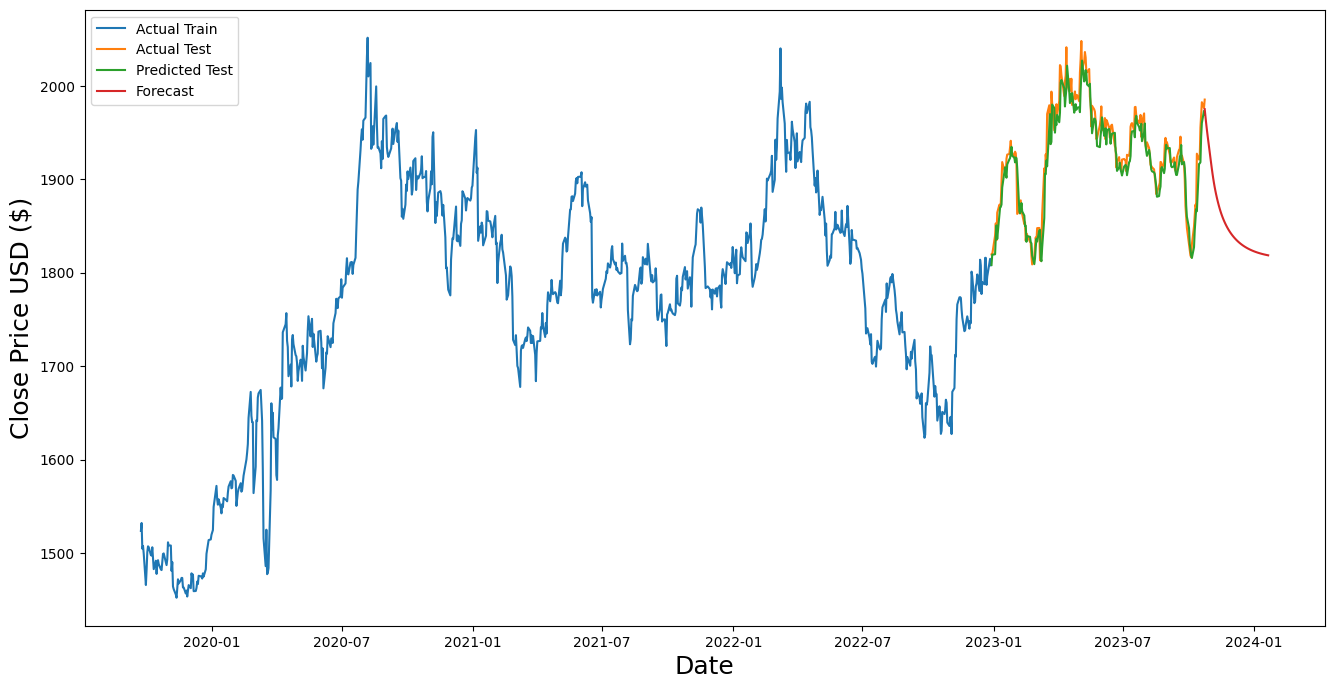

In [ ]:
#Visualize the data
import matplotlib.dates as mdates

# Set the interval to 3 (quarterly) and specify the month for the start of the quarters

plt.figure(figsize= (16, 8))
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.plot(result['Predicted_result'])
plt.legend(['Actual Train','Actual Test', 'Predicted Test', 'Forecast'])
plt.show()

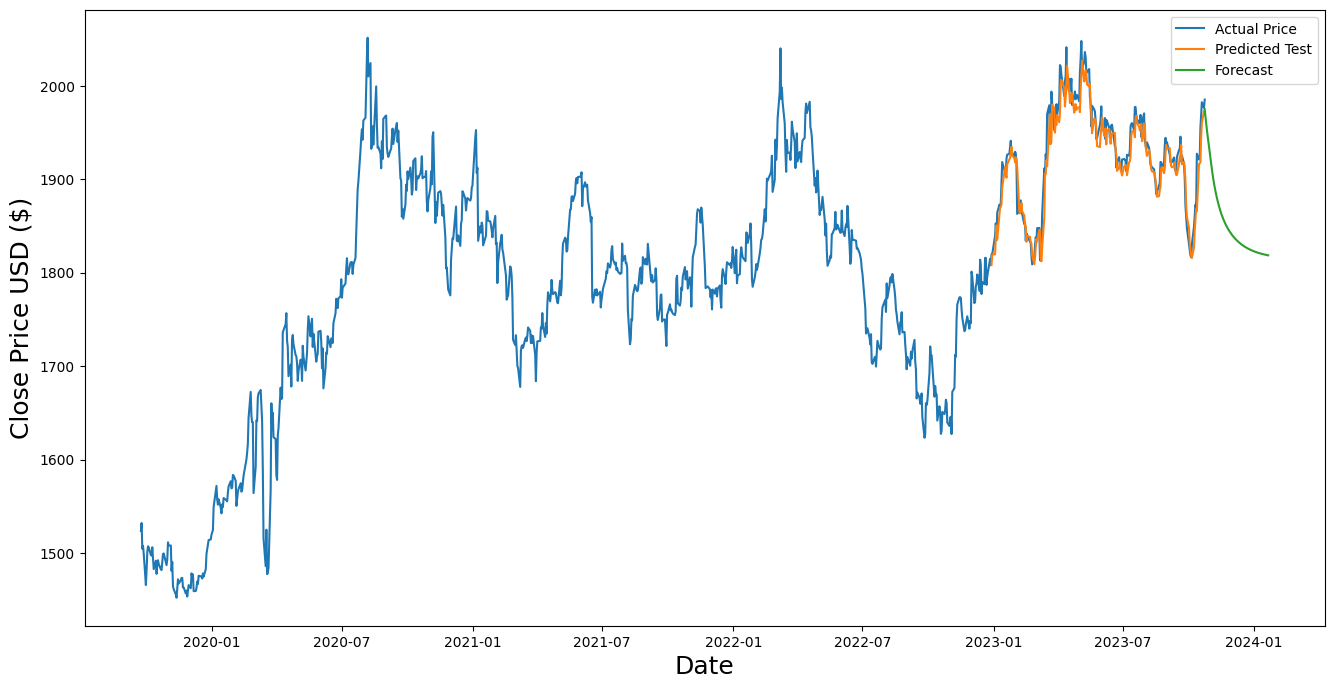

In [ ]:
# Set the interval to 3 (quarterly) and specify the month for the start of the quarters

plt.figure(figsize= (16, 8))
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.plot(data)
plt.plot(valid[['Predictions']])
plt.plot(result['Predicted_result'])
plt.legend(['Actual Price', 'Predicted Test', 'Forecast'])
plt.show()